In [12]:
import sys, os, re
import importlib
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d, percentile_filter
from scipy.stats import binned_statistic, zscore
import scipy.stats as stats
import suite2p 
from suite2p.extraction import dcnv
import pandas as pd
import yaml
import copy
import glob 
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import wesanderson
from cycler import cycler
import palettes
pio.renderers.default = "browser"

import neural_analysis_helpers
importlib.reload(neural_analysis_helpers)

from neural_analysis_helpers import get_psth, plot_avg_psth, split_psth, get_tuned_neurons, plot_avg_goal_psth, \
    get_landmark_psth, plot_avg_landmark_psth, plot_landmark_psth_map, plot_condition_psth_map, get_map_correlation, \
    get_tuned_neurons_shohei, plot_goal_psth_map, plot_all_sessions_goal_psth_map, get_map_correlation_matrix

tm_palette = palettes.met_brew('Tam',n=123, brew_type="continuous")
tm_palette = tm_palette[::-1]
color_scheme = wesanderson.film_palette('Darjeeling Limited',palette=0)
custom_cycler = cycler(color=color_scheme)

hfs_palette = np.array(palettes.met_brew('Archambault',n=20, brew_type="continuous"))

In [236]:
# Load tracked and aligned ROIs
sessions_to_align = ['ses-011_date-20250315_protocol-t5', 'ses-012_date-20250318_protocol-t6']
num_sessions = len(sessions_to_align)
protocol_nums = [int(re.search(r'protocol-t(\d+)', s).group(1)) for s in sessions_to_align]

basepath = Path('/media/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2')
animal = 'TAA0000066'
func_img_path = 'funcimg/Session'
tracking_path = basepath / animal / '_'.join(f't{n}' for n in protocol_nums)
savepath = tracking_path / 'analysis' 

suffix = '_'.join(f't{n}' for n in protocol_nums)
filename = f'roicat_aligned_ROIs_{suffix}.npy'
if os.path.exists(os.path.join(tracking_path, filename)):
    idx_original_aligned = np.load(os.path.join(tracking_path, filename))
else:
    raise FileNotFoundError('The ROICaT alignment file is not found in this directory.')
    

In [237]:
# Load DF_F 
session_data = [[] for s in range(num_sessions)]

for s, sess in enumerate(sessions_to_align):
    DF_F_file = os.path.join(basepath, animal, sess, func_img_path, 'suite2p/plane0/DF_F0.npy')
    valid_frames_file = os.path.join(basepath, animal, sess, 'valid_frames.npz')

    if os.path.exists(DF_F_file) and os.path.exists(valid_frames_file):
        valid_frames = np.load(valid_frames_file)['valid_frames']

        DF_F_all = np.load(DF_F_file)
        DF_F = DF_F_all[:, valid_frames]
        session_data[s] = DF_F
    else:
        raise FileNotFoundError('Either the valid_frames.npz or the DF_F0.npy file does not exist in this directory.')


Common neurons considered across all sessions: 155


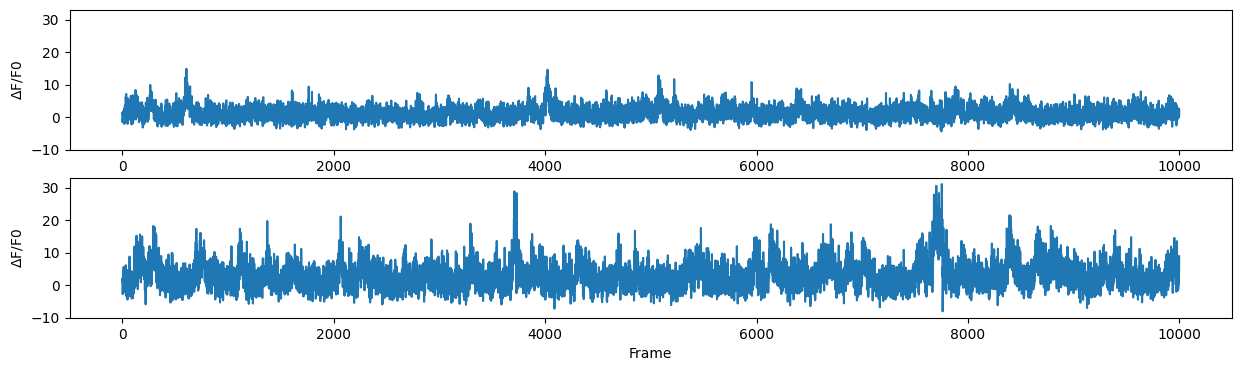

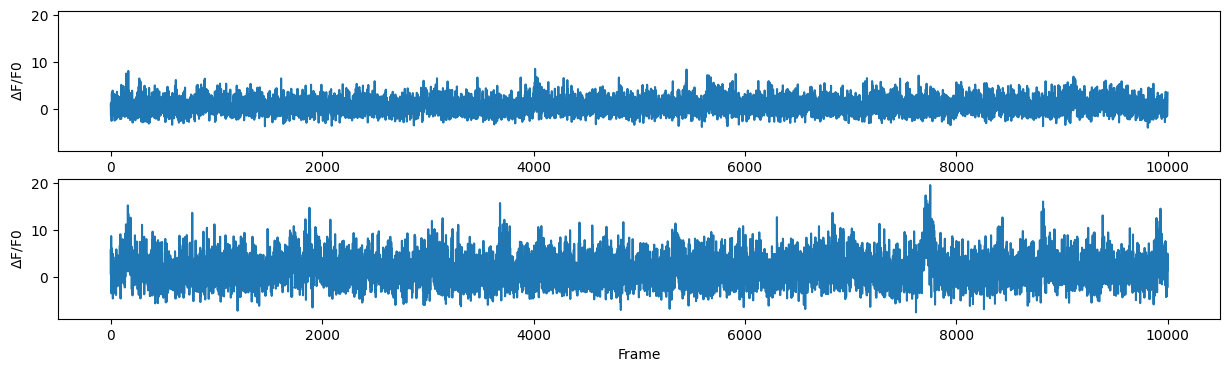

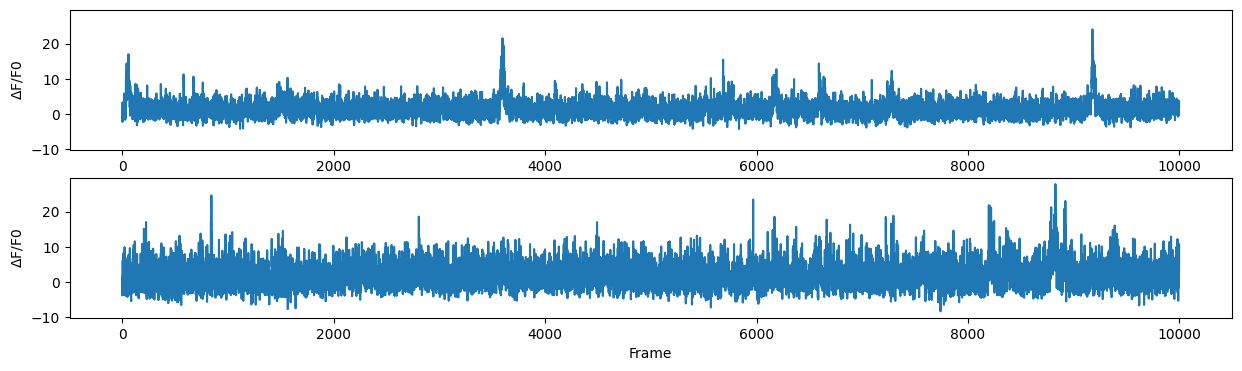

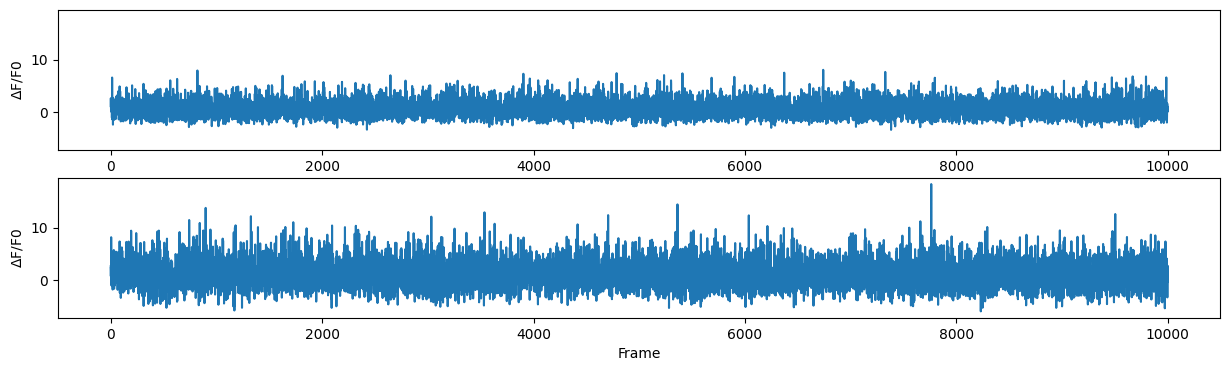

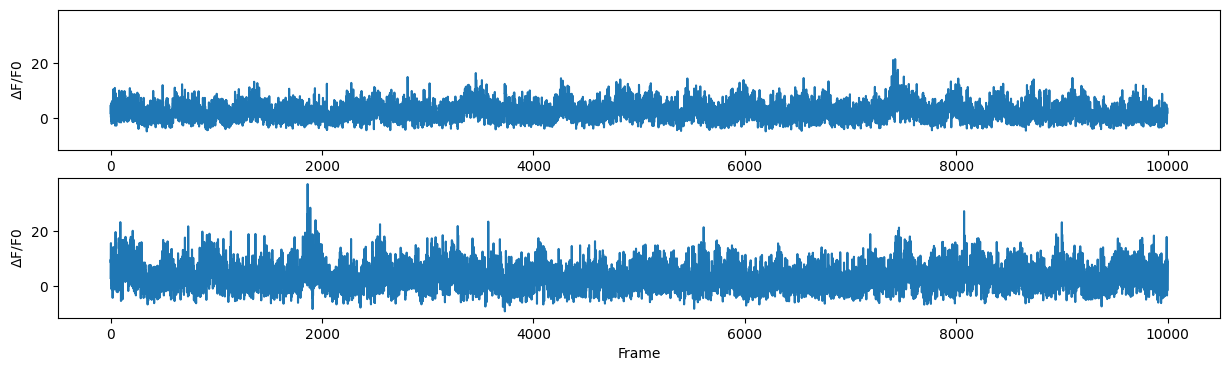

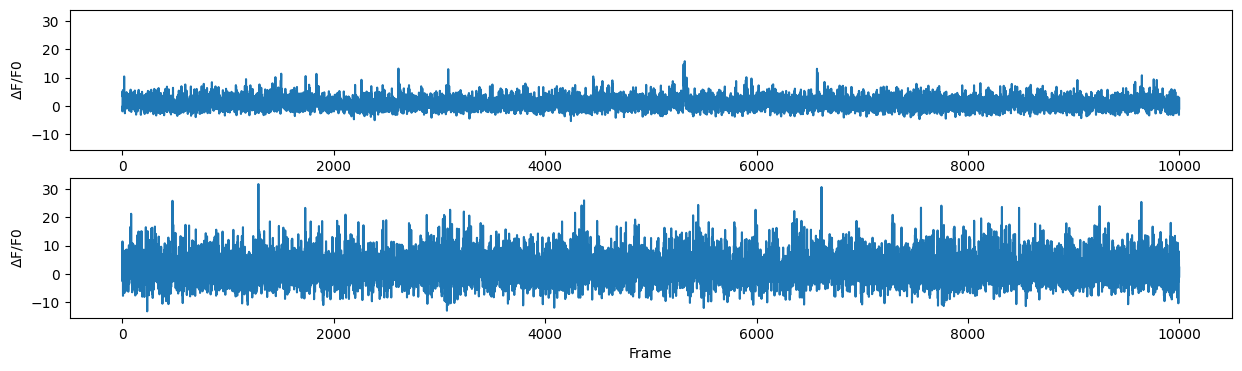

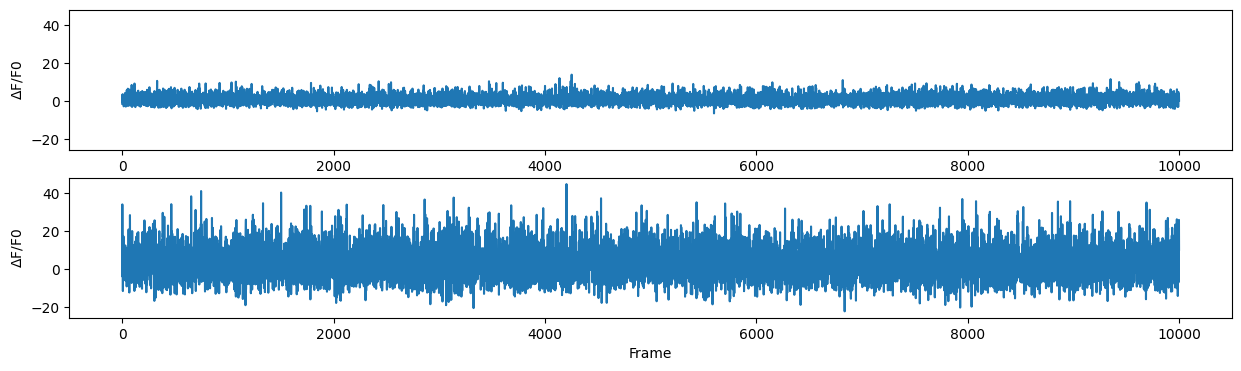

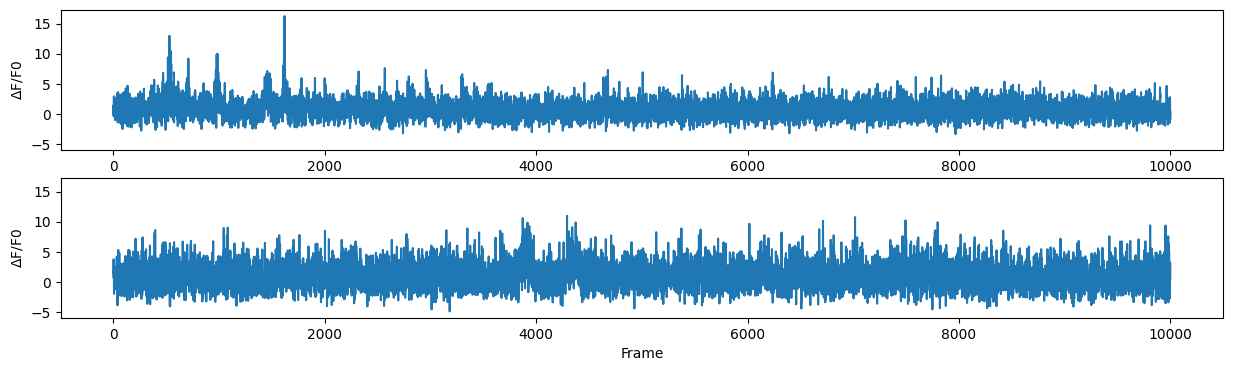

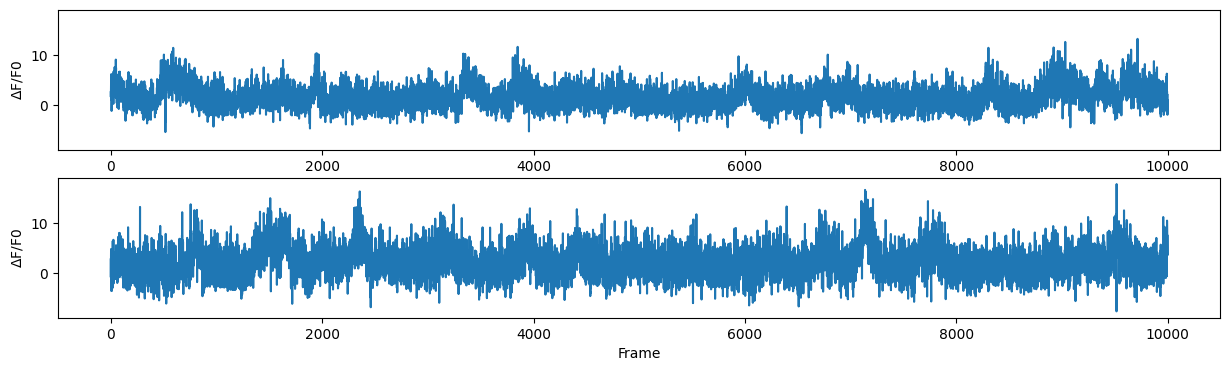

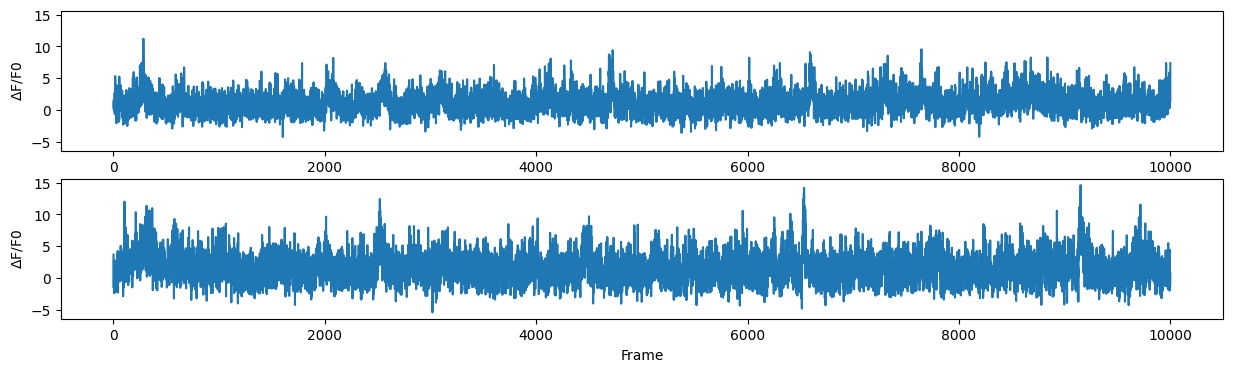

In [238]:
# Look at distribution of DF/F to select neurons

# Keep neurons that have been clustered in all sessions
idx_array = np.vstack(idx_original_aligned)  # shape: (n_sessions, n_neurons)
valid_mask = np.all(~np.isnan(idx_array), axis=0)  # Find neurons that are not nan in all sessions
valid_indices = np.where(valid_mask)[0]  # Get the indices that are valid across all sessions

# Find indices of neurons that have good signal in all sessions and are tracked across sessions
consistent_neurons = [[] for s in range(num_sessions)]
for s in range(num_sessions):
    for n, neuron in enumerate(np.array(idx_original_aligned[s][valid_indices]).astype(int)):
        deltas = session_data[s][neuron,:] - np.mean(session_data[s][neuron,:])
        # plt.hist(deltas, bins=100)
        skew = stats.skew(deltas)

        if skew > 0.5:
            consistent_neurons[s].append(n)

neuron_sets = [set(neurons) for neurons in consistent_neurons]
common_neuron_idx = list(set.intersection(*neuron_sets))  # indices of neurons
print("Common neurons considered across all sessions:", len(common_neuron_idx))

# Get the ids of these neurons  
neurons_considered_sessions = [[] for s in range(num_sessions)]  
for s in range(num_sessions):
    for neuron in np.array(idx_original_aligned[s][valid_indices[common_neuron_idx]]).astype(int):
        neurons_considered_sessions[s].append(neuron)

# Plot a few neurons
plot_range = 10000
xdata = np.arange(0, plot_range) 
for n in range(0,10):
    fig, ax = plt.subplots(num_sessions, 1, figsize=(15,4), sharey=True)
    ax = ax.ravel()
    for s in range(num_sessions):
        ax[s].plot(xdata, session_data[s][neurons_considered_sessions[s][n],0:plot_range])
        ax[s].set_xlabel('Frame')
        ax[s].set_ylabel('$\Delta$F/F0')

In [239]:
# Identify common neurons that are tuned to rewards
# NOTE: singificant neurons for each event are indices into that session's neurons_considered, 
# which are in turn the actual ROI ids. 

time_around = 0.5  # window around events

all_significant_neurons_reward = [[] for s in range(num_sessions)]
significant_neurons_reward_id = [[] for s in range(num_sessions)]
reward_tuned_neurons_sessions = [[] for s in range(num_sessions)]
neurons_considered = [[] for s in range(num_sessions)]
tracked_reward_tuned_neurons = [[] for s in range(num_sessions)] # reward-tuned neurons across sessions
tracked_reward_tuned_idx = [[] for s in range(num_sessions)]
results_rewards = [[] for s in range(num_sessions)]

for s, (prot, sess) in enumerate(zip(protocol_nums, sessions_to_align)):

    analysis_path = os.path.join(basepath, animal, sess, 'analysis')
    neurons_considered_file = np.load(os.path.join(analysis_path, f'T{prot}_neurons_considered.npz'), allow_pickle=True)
    neurons_considered[s] = neurons_considered_file['arr_0']

    results_rewards[s] = np.load(os.path.join(analysis_path, f'T{prot}_rewards_analysis_{time_around}s.npz'), allow_pickle=True)
    all_significant_neurons_reward[s] = results_rewards[s]['all_significant_neurons_reward']

    # Reward-tuned neurons for each goal, where the keys correspond to goals: 1:A, 2:B, 3:C, 4:D
    significant_neurons_reward_id[s] = results_rewards[s]['significant_neurons_reward_id']

    # Ids of reward-tuned neurons from each session
    reward_tuned_neurons_sessions[s] = neurons_considered[s][all_significant_neurons_reward[s]]

    # Ids of reward-tuned neurons from each session that have been tracked across sessions
    tracked_reward_tuned_neurons[s] = np.intersect1d(reward_tuned_neurons_sessions[s], neurons_considered_sessions[s])
    print(f'Out of {len(neurons_considered_sessions[s])} neurons considered across all sessions, {len(tracked_reward_tuned_neurons[s])} have been previously identified as reward-tuned in T{prot}.')

    # Indices of reward-tuned neurons from each session inside the tracked array. 
    # The same indices across arrays correspond to the same neurons.
    tracked_reward_tuned_idx[s] = np.where(np.isin(neurons_considered_sessions[s], tracked_reward_tuned_neurons[s]))[0]

# Indices of tracked neurons that are reward-tuned across sessions.
consistent_reward_tuned_neuron_idx = reduce(np.intersect1d, tracked_reward_tuned_idx)


Out of 155 neurons considered across all sessions, 94 have been previously identified as reward-tuned in T5.
Out of 155 neurons considered across all sessions, 116 have been previously identified as reward-tuned in T6.


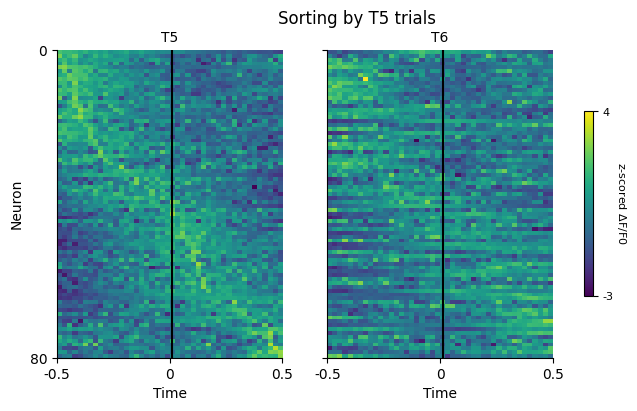

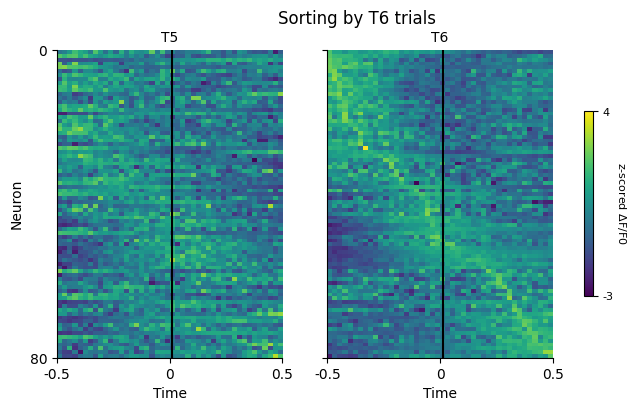

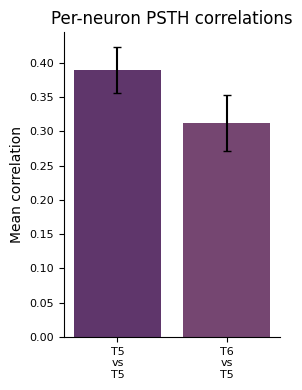

In [240]:
# Plot reward PSTHs for each session
psths = [[] for s in range(num_sessions)]
average_psths = [[] for s in range(num_sessions)]
conditions = [f'T{prot}' for prot in protocol_nums]

for s in range(num_sessions):   
    neurons = np.array(neurons_considered_sessions[s])[consistent_reward_tuned_neuron_idx]  # ids of tracked neurons that are consistently reward-tuned 
    neuron_idx = np.where(np.isin(neurons_considered[s], neurons))[0]   # indices of these neurons inside their original list of neurons considered 

    # print(results_rewards[s]['average_reward_psth'].shape)
    average_psths[s] = results_rewards[s]['average_reward_psth'][neuron_idx]
    psths[s] = results_rewards[s]['reward_psth'][neuron_idx]

plot_condition_psth_map(average_psths, conditions, zscoring=True, time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons')

corrs = get_map_correlation(psths, average_psths, conditions, zscoring=True, reference=0, color_scheme=hfs_palette[np.array(protocol_nums)], \
                            save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons', filename='FiringMap_correlation')
    

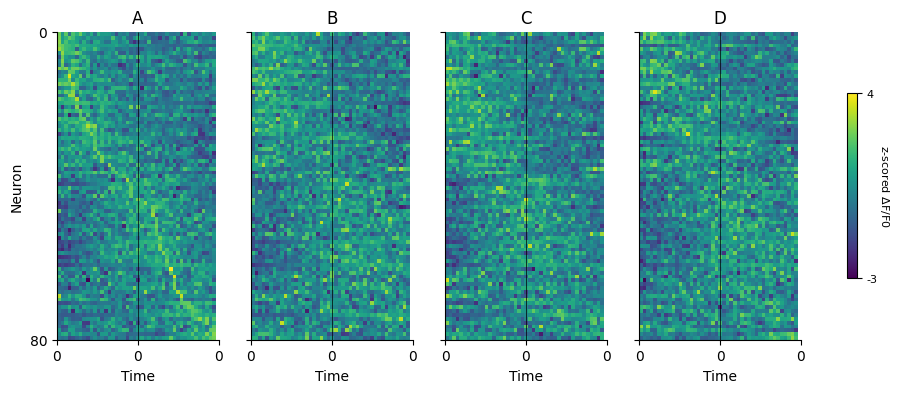

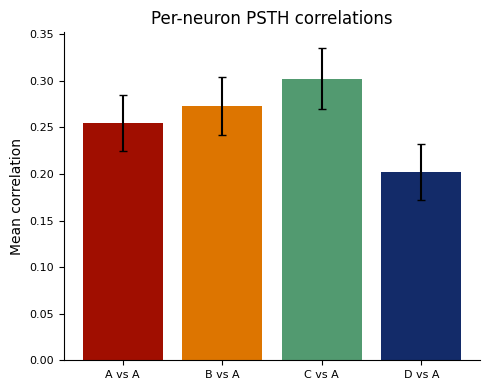

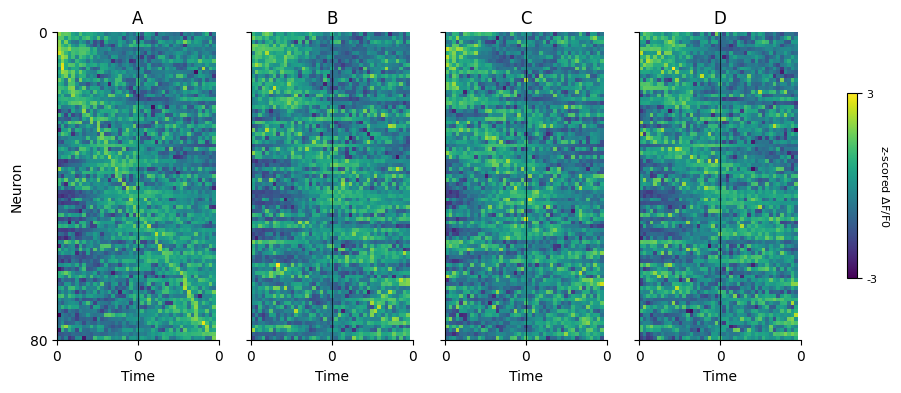

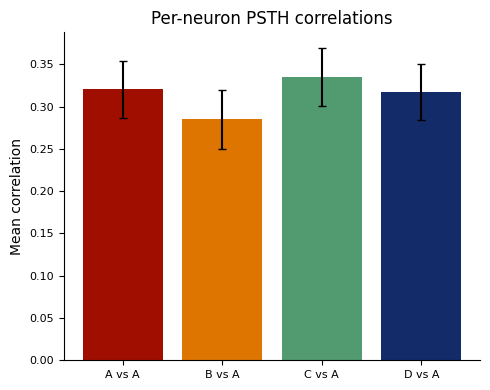

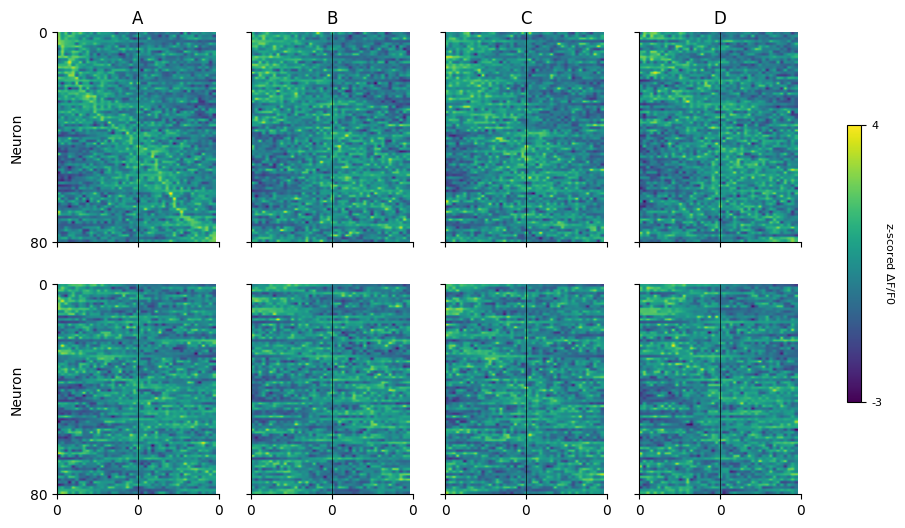

In [241]:
# Plot reward PSTHs for each goal and get correlation across goals 
ABCD_goals = [1,2,3,4]
psths = [{} for _ in range(num_sessions)]
average_psths = [{} for _ in range(num_sessions)]
conditions = ['A','B','C','D']
color_scheme = palettes.met_brew('Johnson', n=len(ABCD_goals), brew_type="continuous")

for s in range(num_sessions):  
    neurons = np.array(neurons_considered_sessions[s])[consistent_reward_tuned_neuron_idx]  # ids of tracked neurons that are consistently reward-tuned 
    neuron_idx = np.where(np.isin(neurons_considered[s], neurons))[0]   # indices of these neurons inside their original list of neurons considered 

    for goal in ABCD_goals:
        psths[s][goal] = results_rewards[s]['reward_id_psth'][()][goal][neuron_idx]
        average_psths[s][goal] = results_rewards[s]['average_reward_id_psth'][()][goal][neuron_idx]

    plot_goal_psth_map(average_psths[s], zscoring=True, sorting_goal=1, time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, \
                       savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_Reward_PSTH_T{protocol_nums[s]}')

    # Plot correlation for each sess among goals 
    corrs = get_map_correlation(psths[s], average_psths[s], conditions, zscoring=True, reference=1, color_scheme=color_scheme, \
                            save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_FiringMap_correlation_T{protocol_nums[s]}')

plot_all_sessions_goal_psth_map(average_psths, zscoring=True, sorting_goal=1, time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, \
                                    savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_Reward_PSTH_allSessions')

Out of 155 neurons considered across all sessions, 48 have been previously identified as T5 A reward-tuned in T5.
Out of 155 neurons considered across all sessions, 52 have been previously identified as T5 A reward-tuned in T6.
Out of 155 neurons considered across all sessions, 48 have been previously identified as T5 B reward-tuned in T5.
Out of 155 neurons considered across all sessions, 61 have been previously identified as T5 B reward-tuned in T6.
Out of 155 neurons considered across all sessions, 47 have been previously identified as T5 C reward-tuned in T5.
Out of 155 neurons considered across all sessions, 41 have been previously identified as T5 C reward-tuned in T6.
Out of 155 neurons considered across all sessions, 48 have been previously identified as T5 D reward-tuned in T5.
Out of 155 neurons considered across all sessions, 67 have been previously identified as T5 D reward-tuned in T6.


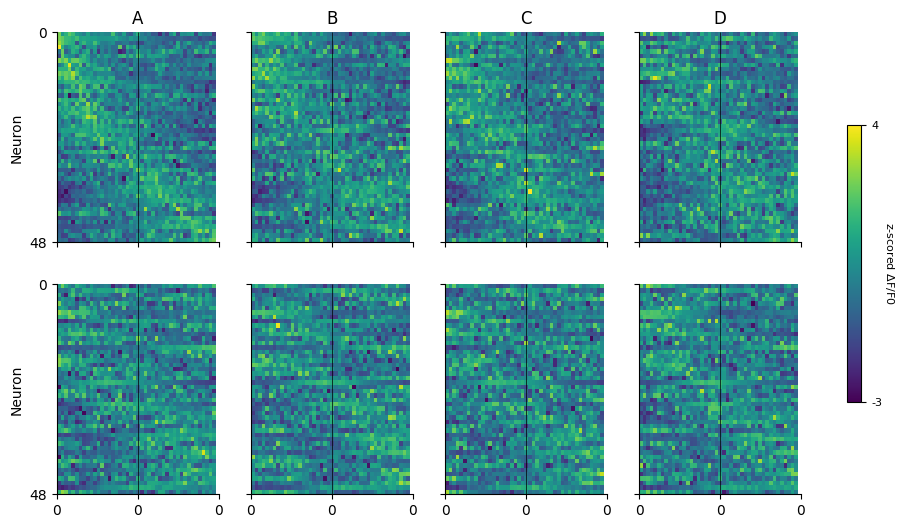

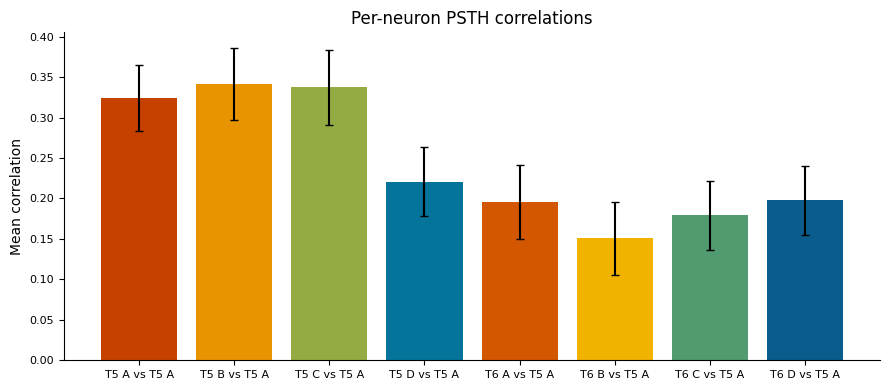

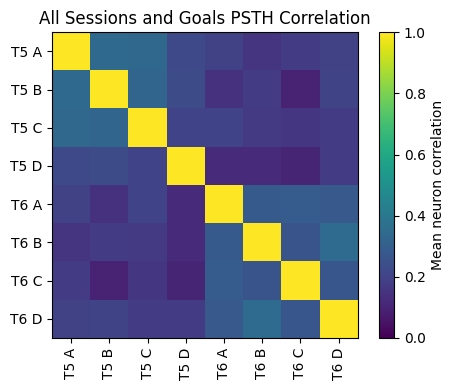

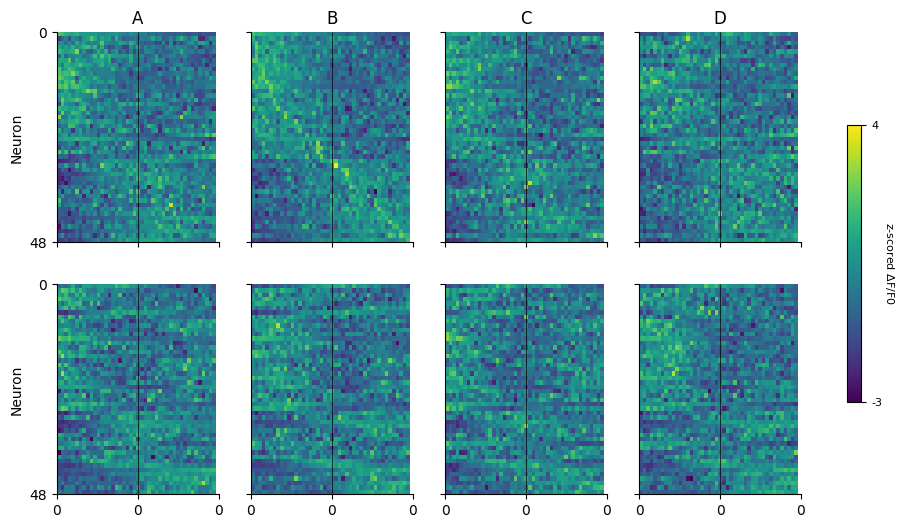

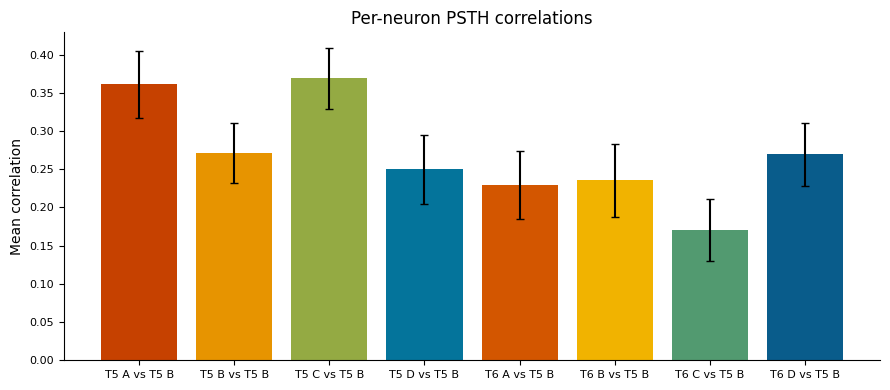

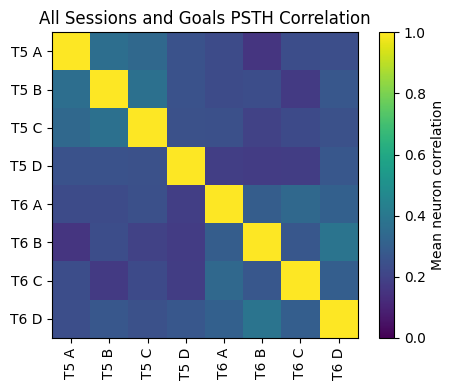

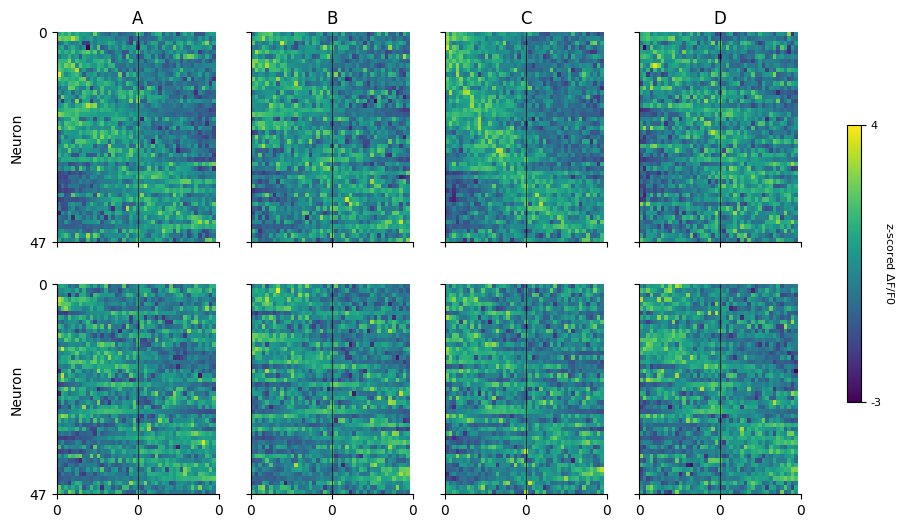

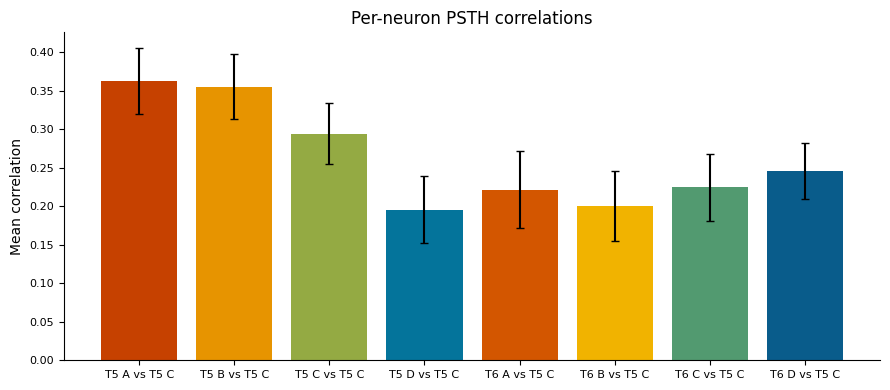

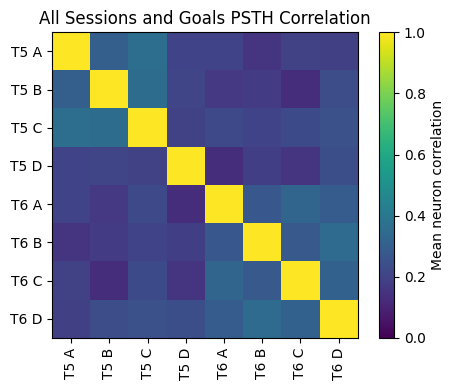

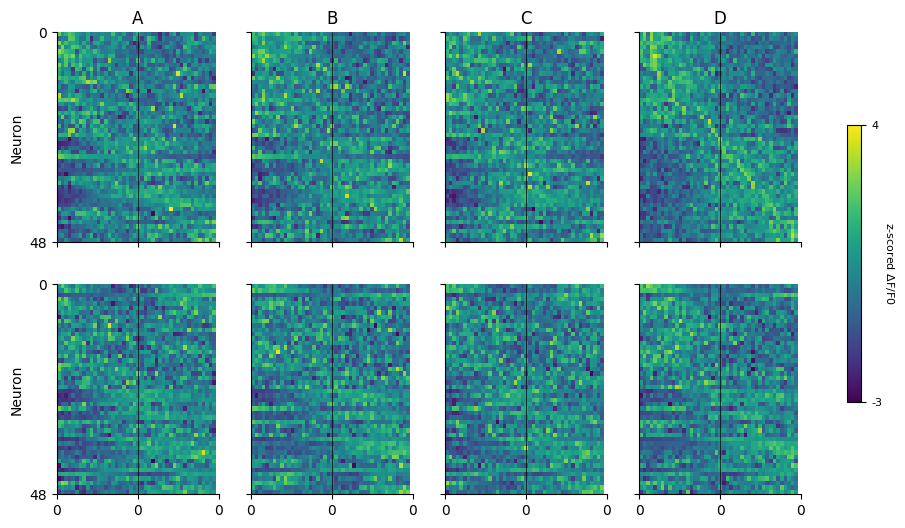

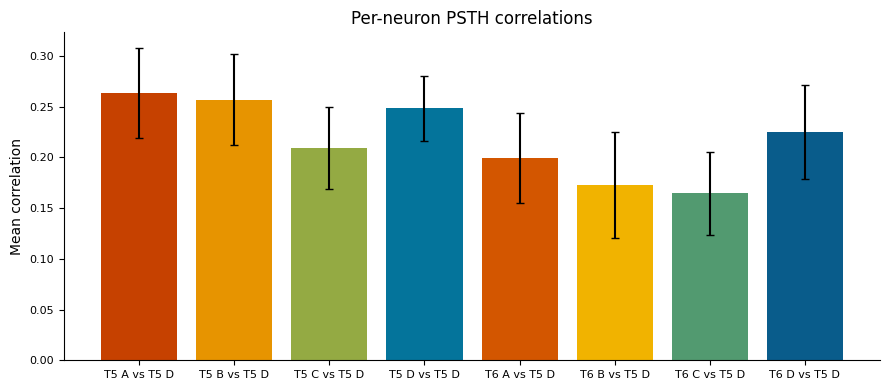

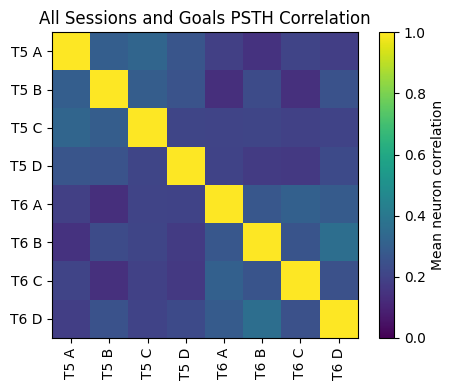

In [242]:
# Compare reward-tuned neurons that are goal-specific across sessions 
ABCD_goals = [1,2,3,4]
ref_prot = 0  # session idx to use as reference i.e. how have things changed compared to that reference. 
goal_ids = ['A','B','C','D']
conditions = [f'T{prot} {goal}' for prot in protocol_nums for goal in goal_ids]
color_scheme = palettes.met_brew('Johnson', n=len(conditions)*2, brew_type="continuous")
color_scheme = [color_scheme[3], color_scheme[6], color_scheme[9], color_scheme[12], color_scheme[4], color_scheme[7], color_scheme[10], color_scheme[13]]

## Get the neurons that are goal-specific and tracked 
tracked_reward_id_tuned_neurons = {s: {goal: [] for goal in ABCD_goals} for s in range(num_sessions)}
tracked_reward_id_tuned_idx = {s: {goal: [] for goal in ABCD_goals} for s in range(num_sessions)}
consistent_reward_id_tuned_neuron_idx = {goal: [] for goal in ABCD_goals}

for g, goal in enumerate(ABCD_goals):
    for s, (prot, sess) in enumerate(zip(protocol_nums, sessions_to_align)):
    
        # Ids of reward-tuned neurons for a specific goal from each session
        tracked_reward_id_tuned_neurons[s][goal] = np.intersect1d(neurons_considered[s][significant_neurons_reward_id[s][()][goal]], neurons_considered_sessions[s])
        print(f'Out of {len(neurons_considered_sessions[s])} neurons considered across all sessions, {len(tracked_reward_id_tuned_neurons[s][goal])} have been previously identified as {conditions[g]} reward-tuned in T{prot}.')

        # Indices of reward-tuned neurons for a specific goal from each session inside the tracked array. 
        tracked_reward_id_tuned_idx[s][goal] = np.where(np.isin(neurons_considered_sessions[s], tracked_reward_id_tuned_neurons[s][goal]))[0]

    # Indices of tracked neurons that are reward-tuned for a specific goal across sessions.
    consistent_reward_id_tuned_neuron_idx[goal] = reduce(np.intersect1d, [tracked_reward_id_tuned_idx[s][goal] for s in range(num_sessions)])
      

## Get PSTH maps and their correlations for each goal compared
for g, (goal, goal_id) in enumerate(zip(ABCD_goals, goal_ids)):
    psths = {s: {goal: [] for goal in ABCD_goals} for s in range(num_sessions)}
    average_psths = {s: {goal: [] for goal in ABCD_goals} for s in range(num_sessions)}

    for s in range(num_sessions):
        # neurons = np.array(neurons_considered_sessions[s])[consistent_reward_id_tuned_neuron_idx[goal]]  # ids of tracked neurons that are consistently reward-tuned 
        neurons = np.array(neurons_considered_sessions[s])[tracked_reward_id_tuned_idx[ref_prot][goal]]    # ids of tracked neurons that are reward-tuned and goal-specific in the *1st session*
        neuron_idx = np.where(np.isin(neurons_considered[s], neurons))[0]   # indices of these neurons inside their original list of neurons considered 

        for psth_goal in ABCD_goals:
            # Extract the reward PSTHs for these neurons
            psths[s][psth_goal] = results_rewards[s]['reward_id_psth'][()][psth_goal][neuron_idx]
            average_psths[s][psth_goal] = results_rewards[s]['average_reward_id_psth'][()][psth_goal][neuron_idx]

    
    plot_all_sessions_goal_psth_map(average_psths, zscoring=True, sorting_goal=goal, time_around=time_around, funcimg_frame_rate=45, save_plot=False, savepath=savepath, \
                                    savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_T{protocol_nums[ref_prot]}-Reward{goal_id}-TunedNeurons_PSTH_allSessions')

    # Get correlation among goals and across sessions compared to reference
    _ = get_map_correlation(psths, average_psths, conditions, zscoring=True, reference=g, color_scheme=color_scheme, \
                            save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_FiringMap_correlation_T{protocol_nums[ref_prot]}-Reward{goal_id}-TunedNeurons')
    
    # Get correlation matrix among goals and across sessions 
    _ = get_map_correlation_matrix(average_psths, conditions, zscoring=True, save_plot=False, savepath=savepath, savedir='RewardPSTH_RewardTunedNeurons', filename=f'ABCD_FiringMap_correlationMatrix_T{protocol_nums[ref_prot]}-Reward{goal_id}-TunedNeurons')


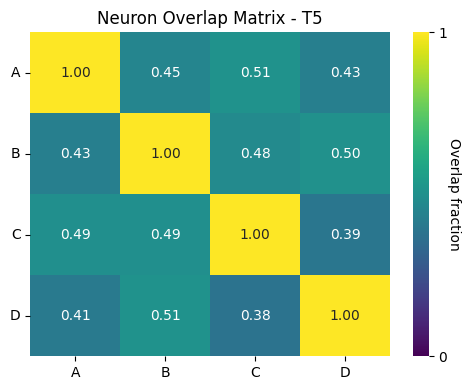

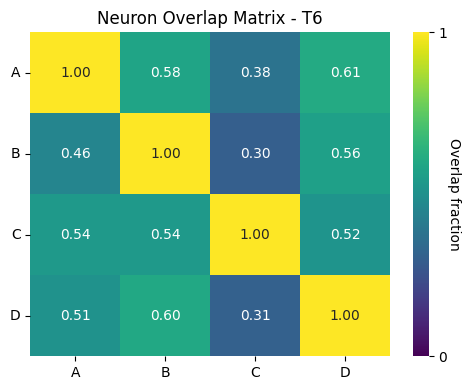

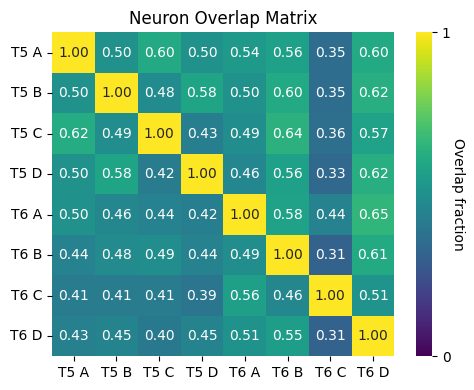

In [ ]:
# Find the overlap in reward-tuned neurons among goals in each session 
save_plot = False
for s in range(num_sessions):
    neuron_overlap_matrix = np.zeros((len(ABCD_goals), len(ABCD_goals)))

    for i, goal in enumerate(ABCD_goals):
        for j, goal_test in enumerate(ABCD_goals):

            neurons1 = neurons_considered[s][significant_neurons_reward_id[s][()][goal]]
            neurons2 = neurons_considered[s][significant_neurons_reward_id[s][()][goal_test]]
            
            overlap = len(np.where(np.isin(neurons1, neurons2))[0])
            perc_overlap = overlap / len(neurons1)
            
            neuron_overlap_matrix[i,j] = perc_overlap
    
    fig, ax = plt.subplots(figsize=(5,4))
    h = sns.heatmap(neuron_overlap_matrix, 
                annot=True,        
                fmt=".2f",          
                cmap="viridis", 
                vmin=0, vmax=1, 
                cbar=True,         
                xticklabels=goal_ids, 
                yticklabels=goal_ids, 
                ax=ax)
    
    cbar = h.collections[0].colorbar
    cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0', '1'])
    ax.set_title(f'Neuron Overlap Matrix - T{protocol_nums[s]}')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

    plt.tight_layout()

    if save_plot:
        output_path = os.path.join(savepath, 'RewardPSTH_RewardTunedNeurons')
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, f'neuron_goal_overlap_matrix_T{protocol_nums[s]}.png'))


# Find the overlap in reward-tuned neurons among goals aross sessions
conditions = [f'T{prot} {goal}' for prot in protocol_nums for goal in goal_ids]

neuron_overlap_matrix = np.zeros((num_sessions * len(ABCD_goals), num_sessions * len(ABCD_goals)))

neurons1 = [{} for _ in range(num_sessions * len(ABCD_goals))]

counter = 0
for s in range(num_sessions):
    for i, goal in enumerate(ABCD_goals):
        neurons1[counter] = tracked_reward_id_tuned_idx[s][goal] #neurons_considered[s][significant_neurons_reward_id[s][()][goal]] TODO: what neurons should I be using here???
        counter += 1

for i in range(num_sessions * len(ABCD_goals)):
    for j in range(num_sessions * len(ABCD_goals)):

        overlap = len(np.where(np.isin(neurons1[i], neurons1[j]))[0])
        perc_overlap = overlap / len(neurons1[i])

        neuron_overlap_matrix[i,j] = perc_overlap
    
fig, ax = plt.subplots(figsize=(5,4))
h = sns.heatmap(neuron_overlap_matrix, 
            annot=True,        
            fmt=".2f",          
            cmap="viridis", 
            vmin=0, vmax=1, 
            cbar=True,         
            xticklabels=conditions, 
            yticklabels=conditions, 
            ax=ax)

cbar = h.collections[0].colorbar
cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0', '1'])
ax.set_title(f'Neuron Overlap Matrix')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

plt.tight_layout()

if save_plot:
    output_path = os.path.join(savepath, 'RewardPSTH_RewardTunedNeurons')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(os.path.join(output_path, f'neuron_goal_overlap_matrix_allSessions.png'))

In [232]:
# What do goal-specific neurons do across sessions? 
# TODO: what do these non-overlapping significant_neurons_reward_id[s][()][goal] do in the other session
save_plot = False
for s in range(num_sessions):
    unique_neurons = [{} for _ in ABCD_goals]
    
    for i, goal in enumerate(ABCD_goals):
        neurons_other_goals = set().union(*[significant_neurons_reward_id[s][()][g] for g in ABCD_goals if g != goal])

        unique_neurons[goal] = np.setdiff1d(significant_neurons_reward_id[s][()][goal], neurons_other_goals)

        print(unique_neurons[goal])
#         for j, goal_test in enumerate(ABCD_goals):
#             non_overlap = len(np.setdiff1d(significant_neurons_reward_id[s][()][goal], significant_neurons_reward_id[s][()][goal_test]))
#             perc_overlap = non_overlap / len(significant_neurons_reward_id[s][()][goal])
            
#             neuron_non_overlap_matrix[i,j] = perc_overlap
    
#     fig, ax = plt.subplots(figsize=(5,4))
#     h = sns.heatmap(neuron_non_overlap_matrix, 
#                 annot=True,        
#                 fmt=".2f",          
#                 cmap="viridis", 
#                 vmin=0, vmax=1, 
#                 cbar=True,         
#                 xticklabels=goal_ids, 
#                 yticklabels=goal_ids, 
#                 ax=ax)
    
#     cbar = h.collections[0].colorbar
#     cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
#     cbar.set_ticks([0, 1])
#     cbar.set_ticklabels(['0', '1'])
#     ax.set_title(f'Neuron Overlap Matrix - T{protocol_nums[s]}')
#     ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

#     plt.tight_layout()

#     if save_plot:
#         output_path = os.path.join(savepath, 'RewardPSTH_RewardTunedNeurons')
#         if not os.path.exists(output_path):
#             os.makedirs(output_path)
#         plt.savefig(os.path.join(output_path, f'neuron_goal_overlap_matrix_T{protocol_nums[s]}.png'))


# # Find the overlap in reward-tuned neurons among goals aross sessions
# conditions = [f'T{prot} {goal}' for prot in protocol_nums for goal in goal_ids]

# neuron_non_overlap_matrix = np.zeros((num_sessions * len(ABCD_goals), num_sessions * len(ABCD_goals)))

# neurons1 = [{} for _ in range(num_sessions * len(ABCD_goals))]

# counter = 0
# for s in range(num_sessions):
#     for i, goal in enumerate(ABCD_goals):
#         neurons1[counter] = significant_neurons_reward_id[s][()][goal]
#         counter += 1

# for i in range(num_sessions * len(ABCD_goals)):
#     for j in range(num_sessions * len(ABCD_goals)):

#         non_overlap = len(np.setdiff1d(neurons1[i], neurons1[j]))
#         perc_overlap = non_overlap / len(neurons1[i])

#         neuron_non_overlap_matrix[i,j] = perc_overlap
    
# fig, ax = plt.subplots(figsize=(5,4))
# h = sns.heatmap(neuron_non_overlap_matrix, 
#             annot=True,        
#             fmt=".2f",          
#             cmap="viridis", 
#             vmin=0, vmax=1, 
#             cbar=True,         
#             xticklabels=conditions, 
#             yticklabels=conditions, 
#             ax=ax)

# cbar = h.collections[0].colorbar
# cbar.set_label('Overlap fraction', rotation=270, labelpad=10)  
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['0', '1'])
# ax.set_title(f'Neuron Overlap Matrix')
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

# plt.tight_layout()

# if save_plot:
#     output_path = os.path.join(savepath, 'RewardPSTH_RewardTunedNeurons')
#     if not os.path.exists(output_path):
#         os.makedirs(output_path)
#     plt.savefig(os.path.join(output_path, f'neuron_goal_overlap_matrix_allSessions.png'))

[  2   6  10  11  12  14  15  21  23  25  26  30  33  35  38  39  41  44
  46  47  51  53  54  55  57  59  60  63  64  66  67  70  74  75  77  79
  82  83  84  86  88  89  92  94  95  96  97 101 104 108 110 113 116 119
 120 121 122 125 129 130 135 138 141 144 146 148 150 155 158 160 162 164
 165 170 172 175 177 178 179 182 186 187 190 191 197 200 203 204 205 206
 208 209 210 214 219 223 224 231 232 234 237 243 244 247 248 249 251 252
 253 254 255 257 259 261 262 264 265 267 268 270 274 278 282 285 286 288
 295 298 299 305 308 317]
[ 10  11  13  15  20  21  23  25  26  30  32  35  36  38  39  41  43  44
  46  47  50  51  53  55  57  59  60  61  62  63  64  66  68  72  74  75
  80  82  83  84  88  89  92  93  94  95  96  97 104 108 110 111 113 114
 116 119 120 121 125 127 128 129 130 131 135 138 140 141 142 143 144 145
 146 148 150 155 157 160 163 164 165 168 175 177 179 181 182 186 187 190
 193 197 198 201 202 203 204 205 206 207 208 214 215 216 217 220 221 222
 223 224 225 226 229 230 

IndexError: list assignment index out of range